[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rsarka34//AsTFSONN/blob/main/model/AsTFSONN.ipynb)

# **AsTFSONN: Time-Frequency Domain Self-Operational Neural Network for Asthmatic Lung Sound Classification**

**Coder: Arka Roy, IIT Patna**

**Submitted to: MeMea, South Korea, 2023**

**Link of the paper:** [**https://ieeexplore.ieee.org/abstract/document/10171911/**](https://ieeexplore.ieee.org/abstract/document/10171911/)

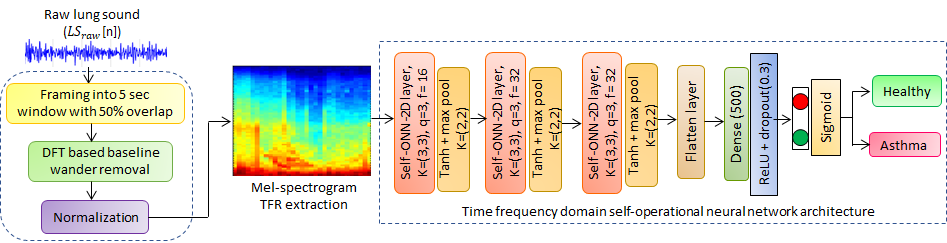


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install mat73
import mat73

### **Mount Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

### **Load Signal Data**

In [ ]:
sig_dict=mat73.loadmat('/content/gdrive/MyDrive/ARKA/Asthma_classification/all_sigs.mat')
sig=sig_dict['all_sig'];
sig=sig.transpose()
sig.shape

(1362, 20000)

### **Labels**

In [ ]:
labels=pd.read_excel('/content/gdrive/MyDrive/ARKA/Asthma_classification/labels.xlsx',header=None)
l=np.array(labels)
label_list=[]
for i in range (1362):
  if l[i]=='Asthma':
    label_list.append(0)
  else:
    label_list.append(1)
Y=np.array(label_list)
Y.shape


(1362,)

### **Create Melspectrogram and Convert Them To 1-channel RGB Image**

In [ ]:
import librosa
r=len(sig[:,1])
nfft=1024
win_length=1024
hop_length=410;sr=4000
audio_rgb_list=[]
d_shape=64

import cv2 as cvlib
for i in range (r):
  clip=sig[i,:]
  mel_spec=librosa.feature.melspectrogram( y=clip, sr=4000,n_mels=64, n_fft=1024, hop_length=410, win_length=1024, window='hann')
  log_spectrogram = librosa.amplitude_to_db(mel_spec)
  norm=(log_spectrogram-np.min(log_spectrogram))/(np.max(log_spectrogram)-np.min(log_spectrogram))
  img = norm
  img=cvlib.resize(img, dsize=(d_shape,d_shape), interpolation=cvlib.INTER_CUBIC)
  audio_rgb_list.append(img)

X=np.array(audio_rgb_list)
print('shape of prev spectrogram dataset'+str(np.shape(X)))
X=np.reshape(X,(1362,1,64,64))
print('shape of one spectrogram dataset'+str(np.shape(X)))

shape of prev spectrogram dataset(1362, 64, 64)
shape of one spectrogram dataset(1362, 1, 64, 64)


### **Create the Neural Network**

In [ ]:
!git clone https://github.com/junaidmalik09/fastonn.git
%cd /content/fastonn
!pip install .
import fastonn
from fastonn import SelfONN2d

Cloning into 'fastonn'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 171 (delta 30), reused 71 (delta 11), pack-reused 70
Receiving objects: 100% (171/171), 555.71 KiB | 19.16 MiB/s, done.
Resolving deltas: 100% (56/56), done.
/content/fastonn
Processing /content/fastonn
  Preparing metadata (setup.py) ... done
  Created wheel for fastonn: filename=fastonn-0.1.1-py3-none-any.whl size=299577 sha256=e3c7d7234ce74bd5c2c21aa5f6f650dcf043e19a5cc6b5028a6432460eaeeed8
  Stored in directory: /tmp/pip-ephem-wheel-cache-sbbjnkpn/wheels/61/8b/99/d8de1ae4507a27413aa8596d19e503645ccfdb3df60b239682
Successfully built fastonn


/content/fastonn/fastonn/utils/utils.py:347: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if val_rate is 0: return [[np.reshape(np.array([indices]),(len(indices),)),np.array([])]]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

In [ ]:
import torch
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

131

In [ ]:
from sklearn.model_selection import train_test_split
def create_datasets(X, y, test_size=0.15,seed=None):
    X_train1, X_test, y_train1, y_test = train_test_split(X, Y, test_size=0.1,random_state=seed)
    print(y_test.shape)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train1, y_train1, test_size=0.1,random_state=seed)
    X_train, X_valid, X_test = [torch.tensor(arr, dtype=torch.float32) for arr in (X_train, X_valid, X_test)]
    y_train, y_valid, y_test = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid, y_test)]

    train_ds = TensorDataset(X_train, y_train)
    valid_ds = TensorDataset(X_valid, y_valid)
    test_ds= TensorDataset(X_test, y_test)
    return train_ds, valid_ds, test_ds


In [ ]:
def create_loaders(train_ds, valid_ds, test_ds, bs, jobs=0):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl,test_dl

In [ ]:
print('Preparing datasets')
trn_ds, val_ds, tst_ds = create_datasets(X,Y,seed=25)

Preparing datasets
(137,)


In [ ]:
bs = 128
print(f'Creating data loaders with batch size: {bs}')
trn_dl, val_dl,tst_dl = create_loaders(trn_ds, val_ds,tst_ds, bs)

Creating data loaders with batch size: 128


In [ ]:
from torch import nn
from torchsummary import summary
from torch.nn import Conv2d

class ONNNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        # 3 conv blocks / flatten / linear / softmax
        self.onnv1 = nn.Sequential(
            SelfONN2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                q=3
            ),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.onnv2 = nn.Sequential(
             SelfONN2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                q=3
            ),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.onnv3 = nn.Sequential(
            SelfONN2d(
                in_channels=32,
                out_channels=32,
                kernel_size=3,
                q=3
            ),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(32*6*6, 500)#
        self.relu=nn.ELU()
        self.dropout =nn.Dropout(p=0.3)
        self.linear2 = nn.Linear(500, 2)
        self.output_l = nn.Softmax()

    def forward(self, input_data):
        x = self.onnv1(input_data)
        x = self.onnv2(x)
        x = self.onnv3(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.dropout(x)
        x= self.dropout(x)
        logits = self.linear2(x)
        predictions = self.output_l(logits)
        return x#logits

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ONNNetwork().to(device)
summary(model, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         SelfONN2d-1           [-1, 16, 62, 62]             448
              Tanh-2           [-1, 16, 62, 62]               0
         MaxPool2d-3           [-1, 16, 31, 31]               0
         SelfONN2d-4           [-1, 32, 29, 29]          13,856
              Tanh-5           [-1, 32, 29, 29]               0
         MaxPool2d-6           [-1, 32, 14, 14]               0
         SelfONN2d-7           [-1, 32, 12, 12]          27,680
              Tanh-8           [-1, 32, 12, 12]               0
         MaxPool2d-9             [-1, 32, 6, 6]               0
          Flatten-10                 [-1, 1152]               0
           Linear-11                  [-1, 500]         576,500
          Dropout-12                  [-1, 500]               0
          Dropout-13                  [-1, 500]               0
           Linear-14                   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


### **Train AsTFSONN**

In [ ]:
lr = 0.001
n_epochs = 252
iterations_per_epoch = len(trn_dl)
num_classes = 2
best_acc = 0
patience, trials = 500, 0
base = 1
step = 2
trainloss_history = []
valacc_history = []
valloss_history = []
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=lr)


print('Start model training')

for epoch in range(1, n_epochs + 1):

    for i, (x_batch, y_batch) in enumerate(trn_dl):
        model.train()
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        opt.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()
    trainloss_history.append(loss)

    with torch.no_grad():
        model.eval()
        correct, total = 0, 0
        for x_val, y_val in val_dl:
            x_val, y_val = [t.cuda() for t in (x_val, y_val)]
            out = model(x_val)
            valid_loss = criterion(out, y_val)
            preds = F.log_softmax(out, dim=1).argmax(dim=1)
            total += y_val.size(0)
            correct += (preds == y_val).sum().item()
    valloss_history.append(valid_loss)
    valid_acc = correct / total
    valacc_history.append(valid_acc)
    print(f'Epoch: {epoch:3d}. Training Loss: {loss:.4f}. Validation Loss: {valid_loss:.4f}. Validation Acc.: {valid_acc:2.2%}')

Start model training


<ipython-input-50-93e6fbaf67e4>:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions = self.output_l(logits)


Epoch:   1. Training Loss: 0.3210. Validation Loss: 0.3136. Validation Acc.: 88.62%
Epoch:   2. Training Loss: 0.2510. Validation Loss: 0.2467. Validation Acc.: 95.93%
Epoch:   3. Training Loss: 0.1246. Validation Loss: 0.2481. Validation Acc.: 91.06%
Epoch:   4. Training Loss: 0.1175. Validation Loss: 0.2139. Validation Acc.: 95.93%
Epoch:   5. Training Loss: 0.0644. Validation Loss: 0.2271. Validation Acc.: 94.31%
Epoch:   6. Training Loss: 0.0963. Validation Loss: 0.1990. Validation Acc.: 95.93%
Epoch:   7. Training Loss: 0.0502. Validation Loss: 0.1885. Validation Acc.: 95.93%
Epoch:   8. Training Loss: 0.0369. Validation Loss: 0.1773. Validation Acc.: 96.75%
Epoch:   9. Training Loss: 0.0606. Validation Loss: 0.2088. Validation Acc.: 95.93%
Epoch:  10. Training Loss: 0.0272. Validation Loss: 0.1952. Validation Acc.: 96.75%
Epoch:  11. Training Loss: 0.0334. Validation Loss: 0.1960. Validation Acc.: 96.75%
Epoch:  12. Training Loss: 0.0210. Validation Loss: 0.2069. Validation Acc.:

### **Test the AsTFSONN**

<ipython-input-50-93e6fbaf67e4>:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions = self.output_l(logits)


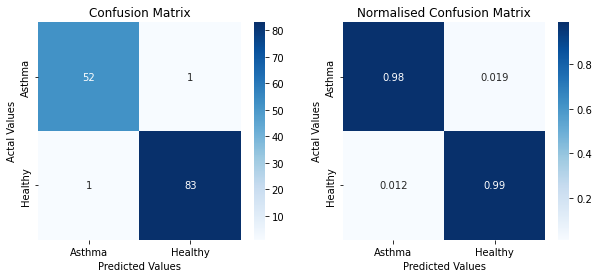

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_true = []
y_pred = []

model.eval()
for x_tst, y_tst in tst_dl:
    xtst_batches = x_tst.cuda()#[t.to(device) for t in (x_tst)]
    out = model(xtst_batches)
    y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    y_hat=y_hat.data.cpu().numpy()
    y_pred.extend(y_hat) # Save preds

    y_tst = y_tst.data.cpu().numpy()
    y_true.extend(y_tst) # Save Truth

from sklearn.metrics import confusion_matrix
import seaborn as sns;
cm=confusion_matrix(y_true,y_pred)
cm_norm=confusion_matrix(y_true,y_pred,normalize='true')
cm_df = pd.DataFrame(cm,
                     index = ['Asthma','Healthy'],
                     columns = ['Asthma','Healthy'])
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.heatmap(cm_df,annot=True,cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

cm_df_norm = pd.DataFrame(cm_norm,
                     index = ['Asthma','Healthy'],
                     columns = ['Asthma','Healthy'])

plt.subplot(122)
sns.heatmap(cm_df_norm,annot=True,cmap="Blues")
plt.title('Normalised Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
    from sklearn.metrics import confusion_matrix
    import sklearn
    cm=confusion_matrix(y_true,y_pred)
    print('Confusion Matrix');
    print(cm)
    precision = sklearn.metrics.precision_score(y_true,y_pred)
    print('precision==   '+str(precision))
    accuracy=np.diag(cm).sum()/cm.sum().sum()
    print('Accuracy==    '+str(accuracy))
    recall = sklearn.metrics.recall_score(y_true,y_pred)
    print('Recall==      '+str(recall))
    F1 = sklearn.metrics.f1_score(y_true,y_pred)
    print('F1-Score==    '+str(F1))
    K_cappa = sklearn.metrics.cohen_kappa_score(y_true,y_pred)
    print('Kcappa==      '+str(K_cappa))

Confusion Matrix
[[52  1]
 [ 1 83]]
precision==   0.9880952380952381
Accuracy==    0.9854014598540146
Recall==      0.9880952380952381
F1-Score==    0.9880952380952381
Kcappa==      0.9692273135669363


### **Save AsTFSONN**

In [ ]:
PATH= "/content/gdrive/MyDrive/ARKA/Asthma_classification/ONN_Results/onn_entire_model.pt"
torch.save(model, PATH)